# Experiment 2: Raw scan to scan registration

### Goal: use VICET to bound error in LIDAR odometry when initializing LOAM from a moving platform 

In [1]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


2023-07-19 09:04:19.895785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 09:04:20.018424: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 09:04:20.425443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-19 09:04:20.425506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-19 09:04:21.319646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 09:04:21.320591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 09:04:21.320882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 09:04:21.321093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
#load HD Map
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1)) 
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [131]:
#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.0368229   0.08058061 -0.00672718  0.00550923 -0.01032399 -0.00310791], shape=(6,), dtype=float32)


In [31]:
#put HD Map and new scan in frame of raw keyframe scan
# idx = 2700 #2750 
idx = 1500 #test
skip = 50 #10 #how many lidar frames between keyframe and new scan
offset = 10 #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"
pc1 = np.load(fn1)
pc2 = np.load(fn2)
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#transform everything to pc1 frame
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314

# #remove 4th column and center first scan about origin
# scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
# scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
# submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

#remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
pc1_too_close = tf.where(pc1_spherical[:,0] < 2. )[:,0]
pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
print(len(pc1_too_close))
pc1 = pc1[pc1_not_too_close.numpy()]
# disp.append(Points(pc1[pc1_too_close.numpy()], c = 'black', r = 5)) #red

# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

plt.show(disp, "05 Quad With Dynamics Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

5333


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [27]:
#run VICET
from linear_corrector import LC
# A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

max_buffer = 2.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 25, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 35, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
#         fid = 50, niter = 100, draw = True, mnp = 50, 
#         RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# # # scan to scan
# dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 100, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
        fid = 50, niter = 50, draw = True, mnp = 50, 
        RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [ 0.07522959 -0.12671717  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0621 -0.1117  0.0073  0.0011  0.0021 -0.0005] 
 [ 0.015   0.0149  0.0071  0.0005 -0.0007 -0.0019]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0507 -0.0992  0.0114  0.002   0.0039 -0.0009] 
 [ 0.0287  0.0273  0.013   0.0006 -0.0015 -0.0035]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.041  -0.0888  0.0126  0.0026  0.0054 -0.0013] 
 [ 0.0409  0.0375  0.0201  0.0008 -0.0022 -0.005 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0325 -0.08    0.0122  0.0032  0.0068 -0.0016] 
 [ 0.052   0.046   0.0273  0.0009 -0.0031 -0.0063]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0248 -0.0722  0.0111  0.0037  0.008  -0.0018] 
 [ 0.0626  0.0524  0.0331  0.0008 -0.004  -0.0076]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0181 -0.0662  0.0097  0.0043  0.009  -0.002 ] 
 [ 0.0717  0.0579  0.0379  0.0005 -0.005  -0.0087]
~~~~

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [28]:
#run rigid ICET
it = ICET(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.01902512 -0.03123545  0.06054747  0.00668528  0.00534035 -0.01631089], shape=(6,), dtype=float32)


<IPython.core.display.Javascript object>


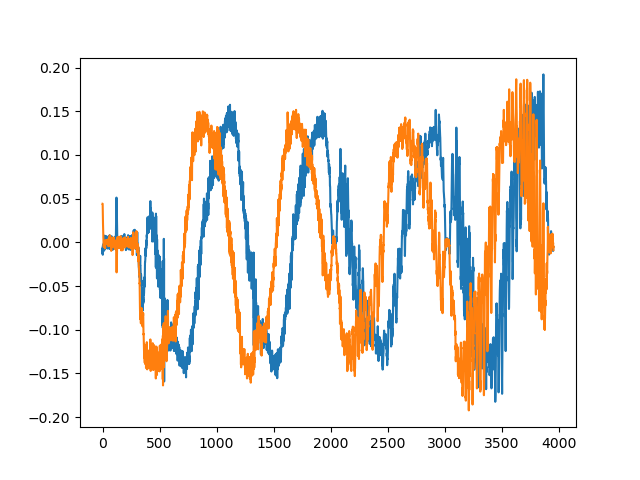

In [29]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(np.diff(poses[:,0,3]))
ax.plot(np.diff(poses[:,1,3]))

## Load LOAM Trajectory Initialzied From Moving Platform

In [121]:
# # start at 2400 (corner near tree) very obvious forward motion distortion
# # rosbag play --clock -s 70.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag

# ## start at 2800
# # # rosbag play --clock -s 110.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# LOAM = np.load("results/LOAM/05_LOAM_start_from_2800_v1.npy")
# start_idx = 2810

## start at 2700
# # rosbag play --clock -s 100.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
LOAM = np.load("results/LOAM/05_LOAM_start_from_2700_v1.npy")
start_idx = 2400

#  Plot on HD Map

In [245]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

fn = "results/LOAM/05_LOAM_start_from_2700_v1.npy"
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:]

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
start_idx = 2689 #2690

end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

#rotate 135 deg about y axis to align initial motion with +x 
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(0), 0]).as_matrix() #was this for 678
rot_mat = R.from_euler('xyz', [np.deg2rad(10), np.deg2rad(31), np.deg2rad(5.5)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat 
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
#was this
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
#test
# gt_lidarframe = (poses[start_idx] @ np.linalg.pinv(initial_pose) @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe = np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1)
# gt_lidarframe = (np.linalg.pinv(initial_pose) @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T


gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(0)]).as_matrix() #test
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(-110)]).as_matrix() #test
gt_points = Line(gt_lidarframe[start_idx:start_idx+len(LOAM_traj),:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
# LOAM_pts = Points(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, r = ptsize).legend("LOAM")
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
# rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix() #old
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(300)]).as_matrix() #new
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

# lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
lb = LegendBox([gt_points, start_point, LOAM_pts], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


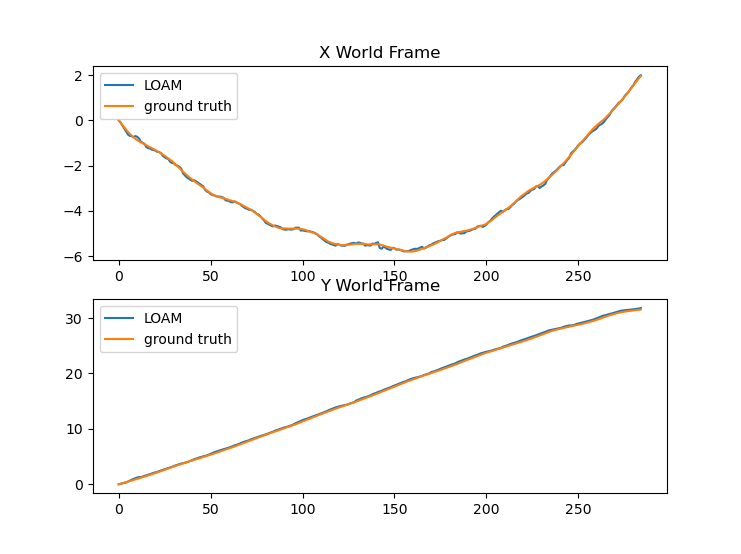

In [244]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(2,1)
gt_x = poses[start_idx:start_idx+len(LOAM),:3,3] - poses[start_idx,:3,3] 

ax[0].set_title("X World Frame")
ax[0].plot(LOAM_corr[:,0], label = 'LOAM')
ax[0].plot(gt_lidarframe[start_idx:start_idx+len(LOAM_corr),0], label = 'ground truth')
ax[0].legend(loc='best')

ax[1].set_title("Y World Frame")
ax[1].plot(LOAM_corr[:,1], label = 'LOAM')
ax[1].plot(gt_lidarframe[start_idx:start_idx+len(LOAM_corr),1], label = 'ground truth')
ax[1].legend(loc='best')

In [ ]:
fig,